In [1]:
## Import required libraries
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import io
import cv2
import random
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Add, MaxPooling2D, \
                                    Conv2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from skimage import io 
from skimage import data, color
from skimage.transform import rotate, rescale, resize
from skimage.util import random_noise

# path = 'C:/Users/user/Jupyter/image-processing/COVID-19_Radiography_Database'
path = '/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database'

# for dirname, _, filenames in os.walk(path):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
imagePaths = []
imageCovidPaths = []
imageNormalPaths = []
imagePneumoniaPaths = []
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))
            if 'COVID' in filename:
                imageCovidPaths.append(os.path.join(dirname, filename))
            if 'NORMAL' in filename:
                imageNormalPaths.append(os.path.join(dirname, filename))
            if 'Pneumonia' in filename:
                imagePneumoniaPaths.append(os.path.join(dirname, filename))

image = cv2.imread(imagePaths[0])
print(image.shape)

(1024, 1024, 3)


In [3]:
print(tf.__version__)
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
labels = ["COVID-19", "NORMAL", "Viral Pneumonia"]

2.3.1


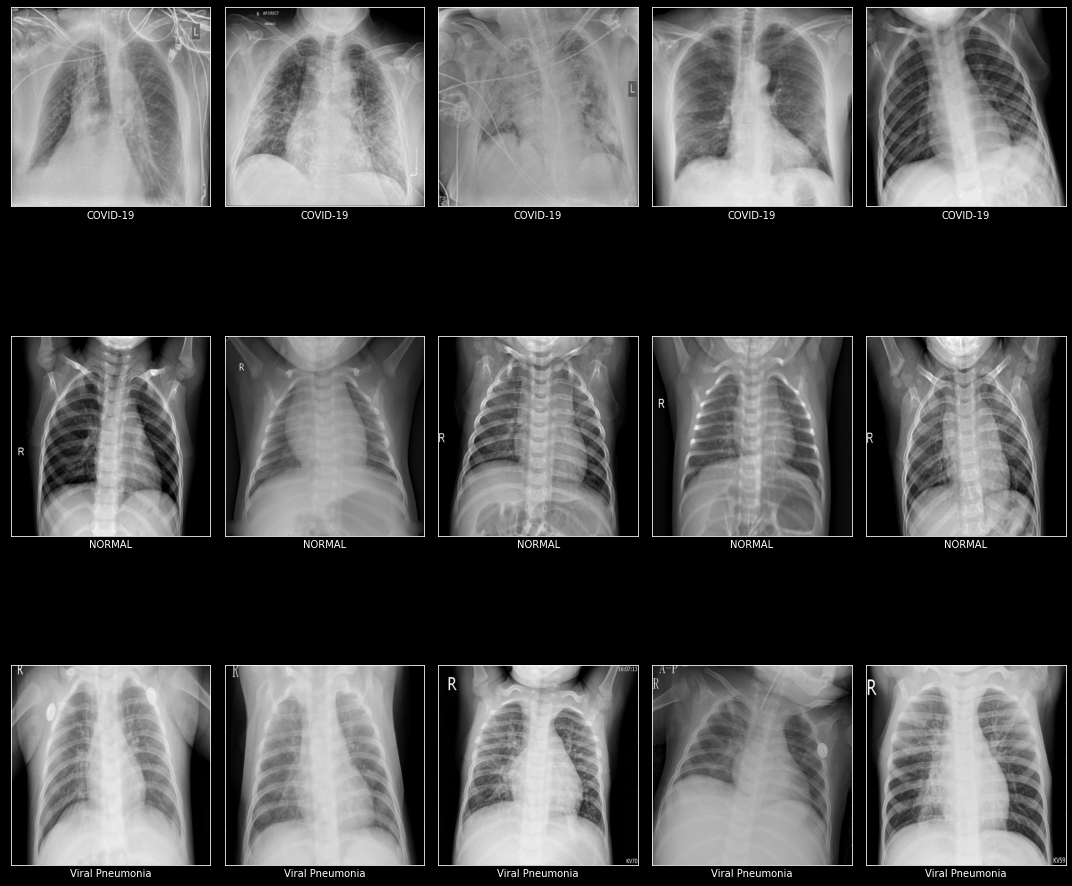

In [4]:
## Visualizing Different Classes
plt.style.use("dark_background")
# Randomly select 5 images in each category
fig, axs = plt.subplots(len(labels), 5, figsize = (15, 15))

class_len = {}
for i, c in enumerate(labels):
    class_path = os.path.join(path, c)
    all_images = os.listdir(class_path)
    sample_images = random.sample(all_images, 5)
    class_len[c] = len(all_images)
    
    for j, image in enumerate(sample_images):
        img_path = os.path.join(class_path, image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = c, xticks = [], yticks = [])
        

fig.tight_layout()

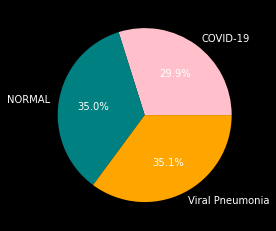

In [5]:
# Inspect the the percentage contribution of each category.
fig, ax = plt.subplots()
ax.pie(
    class_len.values(),
    labels = class_len.keys(),
    autopct = "%1.1f%%",
    colors = ["pink", "teal", "orange"]
)
fig.show()

In [6]:
BATCH_SIZE = 32

datagen_train = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2,
    rotation_range = 5,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    zoom_range = 0.01
)

datagen_val = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2 
)    

train_generator = datagen_train.flow_from_directory(
    directory = path,
    classes = labels,
    seed = SEED,
    batch_size = BATCH_SIZE, 
    shuffle = True,
    interpolation="bilinear",
    follow_links=False,
    subset = 'training'
)

valid_generator = datagen_val.flow_from_directory(
    directory = path,
    classes = labels,
    seed = SEED,
    batch_size = BATCH_SIZE, 
    shuffle = True,
    interpolation="bilinear",
    follow_links=False,
    subset = 'validation'
)

Found 3064 images belonging to 3 classes.
Found 765 images belonging to 3 classes.


In [7]:
# Check out labeling
valid_generator.class_indices

{'COVID-19': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}

In [8]:
base_model = InceptionV3(
    include_top = False, 
    weights = 'imagenet', 
    input_tensor = Input((256, 256, 3)),
)

87916544/87910968 [==============================] - 1s 0us/step


In [9]:
base_model.trainable = True
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
# Add classification head to the model
head_model_start = base_model.output
head_model = GlobalAveragePooling2D()(head_model_start)
head_model = Flatten()(head_model) 
head_model = Dense(256, activation = "relu")(head_model)
head_model = Dropout(0.3)(headmodel)
head_model = Dense(128, activation = "relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(3, activation = "softmax")(head_model) # 3 output classes

cnn_model = Model(inputs = base_model.input, outputs = head_model)
cnn_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [11]:
# Compile the model

# COVID-19 spreads very quickly, it is important that we identify as many cases as possible.
# not care a lot about Flase Positives (precision), because it may be okay 
# to declare normal people as being COVID-19 positive.
# However, we should really care about False Negatives (recall), because it is NOT okay 
# to declare COVID-19 positive people as being normal!

metrics_list = ["accuracy"]
metrics_list += [Recall(class_id = i) for i in range(len(labels))] 
metrics_list += [Precision(class_id = i) for i in range(len(labels))]

cnn_model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = metrics_list
)

In [12]:
# Using early stopping to exit training if recall is 
# not increase even after certain patience (epochs)
earlystopping = EarlyStopping(
    monitor = "recall",
    patience = 20
)

# save the best model with lower loss
checkpointer = ModelCheckpoint(
    filepath = "weights.hdf5", 
    save_best_only = True
)

In [13]:
## Model Training
history = cnn_model.fit_generator(
    train_generator,
    validation_data = valid_generator,
    steps_per_epoch = BATCH_SIZE,
    epochs = 100, 
    callbacks = [earlystopping, checkpointer]
)

Epoch 1/100
32/32 [==============================] - 395s 12s/step - loss: 0.4270 - accuracy: 0.8496 - recall: 0.8488 - recall_1: 0.8201 - recall_2: 0.7756 - precision: 0.9167 - precision_1: 0.8770 - precision_2: 0.8563 - val_loss: 16.6904 - val_accuracy: 0.3516 - val_recall: 0.0000e+00 - val_recall_1: 1.0000 - val_recall_2: 0.0037 - val_precision: 0.0000e+00 - val_precision_1: 0.3531 - val_precision_2: 0.1667
Epoch 2/100
32/32 [==============================] - 393s 12s/step - loss: 0.3561 - accuracy: 0.9055 - recall: 0.9412 - recall_1: 0.8904 - recall_2: 0.8362 - precision: 0.9474 - precision_1: 0.9135 - precision_2: 0.9136 - val_loss: 2.4342 - val_accuracy: 0.3516 - val_recall: 0.0000e+00 - val_recall_1: 1.0000 - val_recall_2: 0.0037 - val_precision: 0.0000e+00 - val_precision_1: 0.3743 - val_precision_2: 0.0270
Epoch 3/100
32/32 [==============================] - 394s 12s/step - loss: 0.2342 - accuracy: 0.9365 - recall: 0.9412 - recall_1: 0.9302 - recall_2: 0.9083 - precision: 0.95

Text(0.5, 1.0, 'Training and Validation Loss')

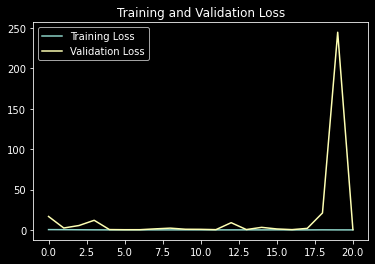

In [14]:
## Evaluation
# Plot training and validation loss per epoch
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

epochs = range(len(train_loss)) 

plt.plot(epochs, train_loss)
plt.plot(epochs, valid_loss)
plt.legend(["Training Loss", "Validation Loss"])
plt.title("Training and Validation Loss")

Text(0.5, 1.0, 'Training and Validation Accuracy')

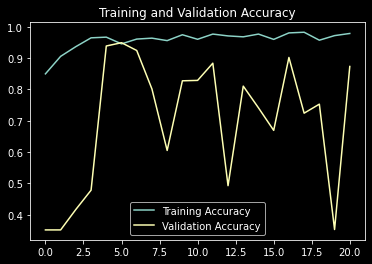

In [15]:
# Plot training and validation accuracy per epoch
train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

epochs = range(len(train_acc)) 

plt.plot(epochs, train_acc)
plt.plot(epochs, valid_acc)
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title("Training and Validation Accuracy")

In [16]:
# save model weights as h5 model
model_json = cnn_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
cnn_model.save("cnn_model.h5")